# Importing necessary libraries

In [72]:
# importing necessary libraries into the code
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import scipy.stats as stats
import re
# import warnings
# warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim

# Load Data
## Import the Cleaned Dataset

In [73]:
#loading the dataset into the dataframes
results = pd.read_csv("results.csv")
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

### Check if the data was successfully loaded or not

In [74]:
results.head()

,season,round,position,grid,lat,long,driverExperience,teamStrength,driverAge,experience_group
0,2009,1,1,1,-37.8497,144.968,9,12.696735,29,High
1,2009,1,2,2,-37.8497,144.968,16,1.000000,36,Very High
2,2009,1,3,20,-37.8497,144.968,12,11.711382,34,High
3,2009,1,4,19,-37.8497,144.968,5,11.676113,27,Medium
4,2009,1,5,10,-37.8497,144.968,8,10.515723,27,High


## Feature and Target Selection

In [75]:
num_features = [
    'season', 'round', 'grid', 'lat', 'long','driverExperience', 
    'teamStrength', 'driverAge']

target = 'position'

## One‑Hot Encoding of Experience Group

In [76]:
X_cat = pd.get_dummies(
    results['experience_group'],
    drop_first = True
)

X_num = results[num_features]

X = pd.concat([X_num, X_cat], axis = 1)
y = results[target]

## Train-Test Split

In [77]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.3,
    random_state = 42
)

X_train.shape, X_test.shape

((4328, 11), (1855, 11))

## Feature Scaling

In [78]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

## Convert Data to PyTorch Tensors

In [79]:
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train_scaled, dtype=torch.float32)

X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_t = torch.tensor(y_test_scaled, dtype=torch.float32)

## Define the ANN Architecture

In [80]:
class ANNModel(nn.Module):
    def __init__(self, input_dim):
        super(ANNModel, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.model(x)

## Initialise Model, Loss, and Optimiser

In [81]:
input_dim = X_train_t.shape[1]

model = ANNModel(input_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

## Train ANN Model

In [82]:
epochs = 1000
train_losses = []

for epoch in range(epochs):
    model.train()
    
    optimizer.zero_grad()
    predictions = model(X_train_t)
    loss = criterion(predictions, y_train_t)
    
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
    
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 0.9871
Epoch 50, Loss: 0.6008
Epoch 100, Loss: 0.5624
Epoch 150, Loss: 0.5488
Epoch 200, Loss: 0.5378
Epoch 250, Loss: 0.5271
Epoch 300, Loss: 0.5157
Epoch 350, Loss: 0.5038
Epoch 400, Loss: 0.4914
Epoch 450, Loss: 0.4784
Epoch 500, Loss: 0.4663
Epoch 550, Loss: 0.4555
Epoch 600, Loss: 0.4455
Epoch 650, Loss: 0.4361
Epoch 700, Loss: 0.4274
Epoch 750, Loss: 0.4204
Epoch 800, Loss: 0.4144
Epoch 850, Loss: 0.4092
Epoch 900, Loss: 0.4043
Epoch 950, Loss: 0.3992


## Training Loss Curve

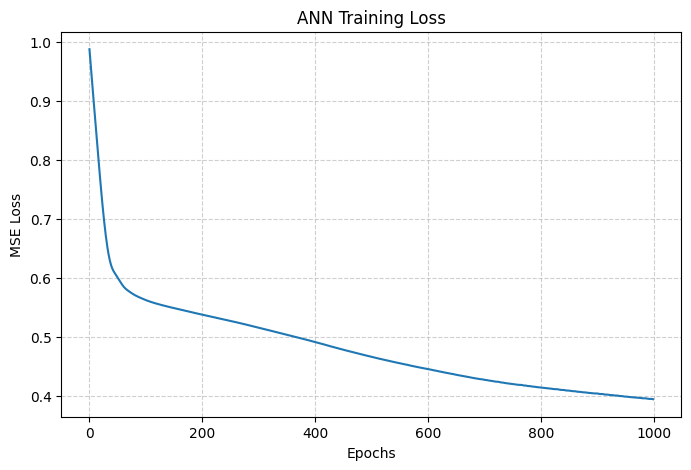

In [83]:
plt.figure(figsize = (8, 5))
plt.plot(train_losses)
plt.title("ANN Training Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.grid(True, linestyle = '--', alpha = 0.6)
plt.show()

## Model Evaluation on Test Set

In [84]:
model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_test_t)
    
    y_pred = scaler_y.inverse_transform(y_pred_scaled.numpy())
    y_test_original = scaler_y.inverse_transform(y_test_t.numpy())

## Evaluation Metrics

In [85]:
mae = mean_absolute_error(y_test_original, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
r2 = r2_score(y_test_original, y_pred)

print(f"ANN MAE : {mae:.2f}")
print(f"ANN RMSE : {rmse:.2f}")
print(f"ANN R² : {r2:.3f}")

ANN MAE : 3.54
ANN RMSE : 4.64
ANN R² : 0.342


## Save the Trained ANN Model

In [86]:
torch.save(model.state_dict(), "ann_f1_model.pth")

# Hyperparameter Tuning

## Train Test Split

In [87]:
# Train–test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.3, random_state = 42
)

# Validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size = 0.3, random_state = 42
)

## Feature Scaling

In [88]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_val   = scaler_X.transform(X_val)
X_test  = scaler_X.transform(X_test)

y_train = scaler_y.fit_transform(y_train.values.reshape(-1,1))
y_val   = scaler_y.transform(y_val.values.reshape(-1,1))
y_test  = scaler_y.transform(y_test.values.reshape(-1,1))

## Convert to tensors

In [89]:
X_train = torch.tensor(X_train, dtype = torch.float32)
X_val   = torch.tensor(X_val, dtype = torch.float32)
X_test  = torch.tensor(X_test, dtype = torch.float32)

y_train = torch.tensor(y_train, dtype = torch.float32)
y_val   = torch.tensor(y_val, dtype = torch.float32)
y_test  = torch.tensor(y_test, dtype = torch.float32)

## ANN Model Definition Flexible Architecture

In [90]:
class ANN(nn.Module):
    def __init__(self, input_dim, hidden_layers):
        super(ANN, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        for h in hidden_layers:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU())
            prev_dim = h
        
        layers.append(nn.Linear(prev_dim, 1))
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

## Hyperparameter Grid

In [91]:
layer_configs = [
    [32],
    [64],
    [64, 32],
    [128, 64]
]

learning_rates = [0.001, 0.01]
epochs = 300

## Training Function

In [92]:
def train_ann(model, optimizer, criterion, epochs):
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = criterion(val_pred, y_val)
            val_losses.append(val_loss.item())
    
    return train_losses, val_losses

## Hyperparameter Tuning Loop

In [93]:
results = []

for layers in layer_configs:
    for lr in learning_rates:
        model = ANN(input_dim = X_train.shape[1], hidden_layers = layers)
        optimizer = optim.Adam(model.parameters(), lr = lr)
        criterion = nn.MSELoss()
        
        train_loss, val_loss = train_ann(model, optimizer, criterion, epochs)
        
        results.append({
            "Layers": layers,
            "Learning Rate": lr,
            "Final Train Loss": train_loss[-1],
            "Final Val Loss": val_loss[-1],
            "Train Curve": train_loss,
            "Val Curve": val_loss
        })

## Select Best Model

In [94]:
results_df = pd.DataFrame(results)
results_df.sort_values("Final Val Loss").head(10)

,Layers,Learning Rate,Final Train Loss,Final Val Loss,Train Curve,Val Curve
2,[64],0.001,0.545129,0.573750,"[1.24574875831604, 1.2229769229888916, 1.20092...","[1.2377790212631226, 1.214540719985962, 1.1920..."
0,[32],0.001,0.550040,0.574982,"[1.040757179260254, 1.030563473701477, 1.02053...","[1.027549386024475, 1.017845630645752, 1.00829..."
4,"[64, 32]",0.001,0.491819,0.591653,"[0.9756543040275574, 0.9584658145904541, 0.942...","[0.9422801733016968, 0.9270867109298706, 0.912..."
1,[32],0.010,0.500529,0.599844,"[1.0653541088104248, 0.9660590291023254, 0.897...","[0.9522243738174438, 0.8853044509887695, 0.836..."
6,"[128, 64]",0.001,0.437234,0.601555,"[1.0542325973510742, 1.0100575685501099, 0.969...","[0.985836923122406, 0.948185920715332, 0.91318..."
3,[64],0.010,0.453904,0.620724,"[1.0368813276290894, 0.876221776008606, 0.7686...","[0.8518239259719849, 0.7491327524185181, 0.685..."
5,"[64, 32]",0.010,0.342110,0.723121,"[0.9838217496871948, 0.8515508770942688, 0.741...","[0.8367710113525391, 0.7323201894760132, 0.642..."
7,"[128, 64]",0.010,0.258790,0.794307,"[0.9752049446105957, 0.7221050262451172, 0.620...","[0.6998069286346436, 0.6098265647888184, 0.681..."


## Learning Curve and Overfitting Analysis

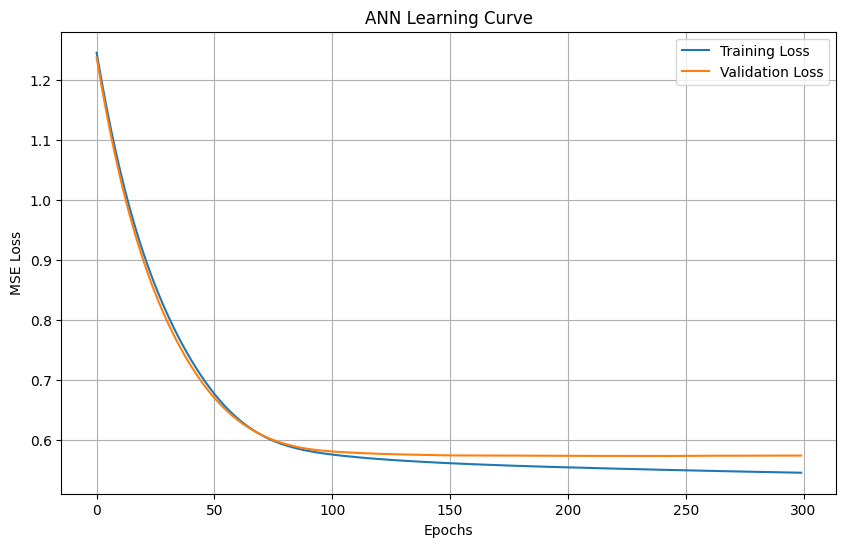

In [95]:
best = results_df.sort_values("Final Val Loss").iloc[0]

plt.figure(figsize = (10,6))
plt.plot(best["Train Curve"], label = "Training Loss")
plt.plot(best["Val Curve"], label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("ANN Learning Curve")
plt.legend()
plt.grid()
plt.show()

# Final Evaluation on Test Set

In [96]:
best_model = ANN(X_train.shape[1], best["Layers"])
optimizer = optim.Adam(best_model.parameters(), lr = best["Learning Rate"])
criterion = nn.MSELoss()

train_ann(best_model, optimizer, criterion, epochs)

([1.0630309581756592,
  1.0475975275039673,
  1.0325980186462402,
  1.0180003643035889,
  1.0037775039672852,
  0.9899231195449829,
  0.9764304161071777,
  0.9632863998413086,
  0.9504819512367249,
  0.9380127787590027,
  0.9258760213851929,
  0.9140574932098389,
  0.9025535583496094,
  0.8913602232933044,
  0.8804678916931152,
  0.8698616027832031,
  0.8595407009124756,
  0.8494893312454224,
  0.8397023677825928,
  0.830174446105957,
  0.8209011554718018,
  0.811869204044342,
  0.8030752539634705,
  0.7945132255554199,
  0.7861801981925964,
  0.7780696153640747,
  0.7701758742332458,
  0.7625002861022949,
  0.7550377249717712,
  0.7477830648422241,
  0.7407290935516357,
  0.7338736057281494,
  0.7272118330001831,
  0.7207418084144592,
  0.7144644260406494,
  0.7083757519721985,
  0.7024767994880676,
  0.6967647075653076,
  0.6912373304367065,
  0.6858939528465271,
  0.6807325482368469,
  0.6757522225379944,
  0.6709514856338501,
  0.6663253903388977,
  0.6618784070014954,
  0.65760713

In [97]:
best_model.eval()
with torch.no_grad():
    y_test_pred = best_model(X_test)

## Inverse scaling

In [98]:
y_test_original = scaler_y.inverse_transform(y_test.numpy())
y_pred_original = scaler_y.inverse_transform(y_test_pred.numpy())

mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
r2 = r2_score(y_test_original, y_pred_original)

print(f"ANN MAE : {mae:.2f}")
print(f"ANN RMSE : {rmse:.2f}")
print(f"ANN R² : {r2:.3f}")

ANN MAE : 3.34
ANN RMSE : 4.36
ANN R² : 0.417


# Inference: Artificial Neural Network Model

## Create new driver input

In [130]:
new_driver = {
    "season": 2024,
    "round": 5,
    "grid": 2,
    "lat": -37.85,
    "long": 144.97,
    "driverExperience": 8,
    "teamStrength": 9,
    "driverAge": 26,
    "Medium": 0,
    "Low": 0,
    "Very High": 1
}

## Convert to DataFrame and align features

In [131]:
new_driver_df = pd.DataFrame([new_driver])

# ensure same column order as training
new_driver_df = new_driver_df.reindex(
    columns=feature_columns,
    fill_value=0
)

## Scale using the SAME scaler

In [132]:
new_driver_scaled = scaler_X.transform(new_driver_df)
new_driver_t = torch.tensor(new_driver_scaled, dtype=torch.float32)

## Forward pass using the TRAINED model

In [133]:
model.eval()

with torch.no_grad():
    y_pred = model(new_driver_t)

## Post‑processing 

In [134]:
y_pred = y_pred.numpy().flatten()

# enforce valid F1 position range
y_pred = np.clip(y_pred, 1, 20)

print(f"Predicted Race Position (ANN): {y_pred[0]:.2f}")

Predicted Race Position (ANN): 1.00


## Batch Prediction 

In [152]:
batch_drivers = pd.DataFrame([
    {"season": 2024, "round": 5, "grid": 1,  "lat": -37.85, "long": 144.97, "driverExperience": 10, "teamStrength": 10, "driverAge": 27, "experience_group": "Very High"},
    {"season": 2024, "round": 5, "grid": 3,  "lat": -37.85, "long": 144.97, "driverExperience": 7,  "teamStrength": 9,  "driverAge": 25, "experience_group": "High"},
    {"season": 2024, "round": 5, "grid": 6,  "lat": -37.85, "long": 144.97, "driverExperience": 5,  "teamStrength": 7,  "driverAge": 24, "experience_group": "Medium"},
    {"season": 2024, "round": 5, "grid": 10, "lat": -37.85, "long": 144.97, "driverExperience": 4,  "teamStrength": 6,  "driverAge": 23, "experience_group": "Medium"},
    {"season": 2024, "round": 5, "grid": 13, "lat": -37.85, "long": 144.97, "driverExperience": 3,  "teamStrength": 5,  "driverAge": 22, "experience_group": "Low"},
    {"season": 2024, "round": 5, "grid": 17, "lat": -37.85, "long": 144.97, "driverExperience": 2,  "teamStrength": 4,  "driverAge": 21, "experience_group": "Low"},
    {"season": 2024, "round": 5, "grid": 20, "lat": -37.85, "long": 144.97, "driverExperience": 1,  "teamStrength": 3,  "driverAge": 20, "experience_group": "Low"},
])

## Saving Feature

In [153]:
# One-hot encode experience_group
batch_cat = pd.get_dummies(batch_drivers["experience_group"], drop_first=True)

# Numerical features
batch_num = batch_drivers[num_features]

# Combine
batch_X = pd.concat([batch_num, batch_cat], axis=1)

# Align columns with training
batch_X = batch_X.reindex(columns=feature_columns, fill_value=0)

In [154]:
batch_X_scaled = scaler_X.transform(batch_X)

In [155]:
batch_X_t = torch.tensor(batch_X_scaled, dtype=torch.float32)


## Forward

In [156]:
with torch.no_grad():
    h1 = batch_X_t @ w1 + b1
    a1 = relu(h1)

    h2 = a1 @ w2 + b2
    a2 = relu(h2)

    y_pred = a2 @ w3 + b3

## Post processing

In [157]:
y_pred = y_pred.numpy().flatten()

# Race positions must be between 1 and 20
y_pred = np.clip(y_pred, 1, 20)

## Making Prediction

In [158]:
batch_results = batch_drivers.copy()
batch_results["Predicted_Position_ANN"] = y_pred
batch_results

,season,round,grid,lat,long,driverExperience,teamStrength,driverAge,experience_group,Predicted_Position_ANN
0,2024,5,1,-37.85,144.97,10,10,27,Very High,NaN
1,2024,5,3,-37.85,144.97,7,9,25,High,NaN
2,2024,5,6,-37.85,144.97,5,7,24,Medium,NaN
3,2024,5,10,-37.85,144.97,4,6,23,Medium,NaN
4,2024,5,13,-37.85,144.97,3,5,22,Low,NaN
5,2024,5,17,-37.85,144.97,2,4,21,Low,NaN
6,2024,5,20,-37.85,144.97,1,3,20,Low,NaN
